In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Flatten, Reshape

### **Load the Saved Preprocessed Data with Aspects**

In [ ]:
data = pd.read_csv("data.csv")
data.head()

,processed_review,text_aspect_sentiment
0,great phone budget pubg performance rough came...,['great phone budget pubg performance rough ca...
1,well smartphone mi range bear r confuse samsun...,['well smartphone mi range bear r confuse sams...
2,bad smooth phone back camera quality bad rear ...,['bad smooth phone back camera quality bad rea...
3,thise nice mobile I like much delivery also fa...,[]
4,I meagerly dissatisfy thumb section r superb d...,['I meagerly dissatisfy thumb section r superb...


#### **Removal of Null Samples**

In this step, the code is performing the following operations:

1. **Creating a Boolean Mask:**
   - A boolean mask is created using the condition `data['text_aspect_sentiment'] == '[]'`.
   - This mask will be `True` for rows where the value in the 'text_aspect_sentiment' column is equal to the string '[]' (an empty set of square brackets).

2. **Inverting the Mask:**
   - The `~` (tilde) operator is used to invert the boolean mask.
   - This inversion results in a mask where `True` corresponds to rows that do not have '[]' in the 'text_aspect_sentiment' column, and `False` corresponds to rows with '[]'.

3. **Filtering the Data:**
   - The inverted mask is applied to the original DataFrame (`data`) using boolean indexing.
   - The resulting `filtered_data` contains only the rows where the 'text_aspect_sentiment' column does not have the value '[]'.


In [ ]:
# Create a boolean mask to identify rows where 'text_aspect_sentiment' is '[]'
mask = data['text_aspect_sentiment'] == '[]'

# Invert the mask to keep rows that don't have '[]'
filtered_data = data[~mask]

In [ ]:
filtered_data.head()

,processed_review,text_aspect_sentiment
0,great phone budget pubg performance rough came...,['great phone budget pubg performance rough ca...
1,well smartphone mi range bear r confuse samsun...,['well smartphone mi range bear r confuse sams...
2,bad smooth phone back camera quality bad rear ...,['bad smooth phone back camera quality bad rea...
4,I meagerly dissatisfy thumb section r superb d...,['I meagerly dissatisfy thumb section r superb...
5,great product price segmentit deliver well per...,['great product price segmentit deliver well p...


In [ ]:
print('Original data: ', data.shape)
print('Filtered data:', filtered_data.shape)

Original data:  (9606, 2)
Filtered data: (9012, 2)


The augmented data had 9606 rows and 2 columns. After applying the filtering operation to remove rows where the 'text_aspect_sentiment' column is equal to '[]', the filtered data now consists of 9012 rows and 2 columns. The reduction in the number of rows from 9606 to 9012 indicates that some rows were removed during the filtering process, keeping only those rows where 'text_aspect_sentiment' does not have the value '[]'.

### **Decoding - Data Preparation**

The code uses the `eval` function to convert the string representation of a list in the `text_aspect_sentiment` column to an actual list. It then iterates over each element in this list, splitting it into parts using specific delimiters ('aaaa' and 'xxxx').

The separated parts include the sentence, aspect, and sentiment information. These parts are then appended to separate lists (`sentences`, `aspects`, and `sentiments`). Finally, a new DataFrame (`text_aspect_sentiment_data`) is created using these lists, with columns for the separated data: 'sentence', 'aspect', and 'sentiment'. The entire process is timed using `%%time` to measure the execution time.

In [ ]:
%%time

# Create empty lists to store the separated data
sentences = []
aspects = []
sentiments = []

# Loop over each row in the DataFrame
for index, row in filtered_data.iterrows():
    # Convert the string representation of the list to an actual list
    text_aspect_sentiment_list = eval(row['text_aspect_sentiment'])

    # Loop over each element in the list
    for text in text_aspect_sentiment_list:
        # Split the text using the specified delimiters
        parts = text.split('aaaa')
        sentence = parts[0]
        aspect = parts[1].split('xxxx')[0]
        sentiment = int(parts[1].split('xxxx')[1])

        # Append the separated data to the respective lists
        sentences.append(sentence)
        aspects.append(aspect)
        sentiments.append(sentiment)

# Create a new DataFrame with the separated data
text_aspect_sentiment_data = pd.DataFrame({
    'sentence': sentences,
    'aspect': aspects,
    'sentiment': sentiments
})


CPU times: user 1.21 s, sys: 16.7 ms, total: 1.22 s
Wall time: 2.48 s


In [ ]:
text_aspect_sentiment_data.head()

,sentence,aspect,sentiment
0,great phone budget pubg performance rough came...,phone,0
1,great phone budget pubg performance rough came...,camera,0
2,great phone budget pubg performance rough came...,performance,0
3,well smartphone mi range bear r confuse samsun...,phone,0
4,well smartphone mi range bear r confuse samsun...,price,0


#### Sentiment Distribution

In [ ]:
text_aspect_sentiment_data.sentiment.value_counts()

1    17774
0     6644
Name: sentiment, dtype: int64

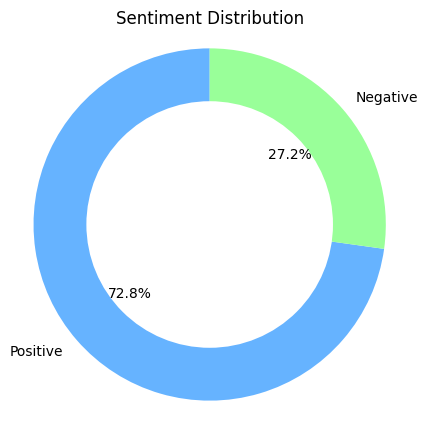

In [ ]:
# Count the occurrences of each sentiment
sentiment_counts = text_aspect_sentiment_data['sentiment'].value_counts()

# Set up figure and axis
plt.figure(figsize=(5,5))

# Create a donut chart
plt.pie(sentiment_counts, labels=['Positive', 'Negative'], autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#99ff99'])

# Draw a white circle at the center to create a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that the donut chart is circular
plt.axis('equal')
plt.title('Sentiment Distribution')
plt.show()


- **Positive Sentiment (Label 1):**
  - Appears in 17774 instances.

- **Negative Sentiment (Label 0):**
  - Appears in 6644 instances.

These counts represent the distribution of sentiment labels in the dataset. The higher count for Label 1 suggests that there are more instances of positive sentiment compared to negative sentiment.

#### Aspect Distribution

In [ ]:
text_aspect_sentiment_data.aspect.value_counts()

phone           5296
camera          4786
battery         3590
price           2485
performance     2380
product         1978
display         1866
quality         1756
acamera           69
aphone            62
aperformance      33
aprice            32
abattery          31
aquality          26
adisplay          18
aproduct          10
Name: aspect, dtype: int64

In [ ]:
text_aspect_sentiment_data['aspect'] = text_aspect_sentiment_data['aspect'].str.replace(r'\baphone\b', 'phone', regex=True)
text_aspect_sentiment_data['aspect'] = text_aspect_sentiment_data['aspect'].str.replace(r'\bacamera\b', 'phone', regex=True)
text_aspect_sentiment_data['aspect'] = text_aspect_sentiment_data['aspect'].str.replace(r'\baperformance\b', 'phone', regex=True)
text_aspect_sentiment_data['aspect'] = text_aspect_sentiment_data['aspect'].str.replace(r'\baprice\b', 'phone', regex=True)
text_aspect_sentiment_data['aspect'] = text_aspect_sentiment_data['aspect'].str.replace(r'\babattery\b', 'phone', regex=True)
text_aspect_sentiment_data['aspect'] = text_aspect_sentiment_data['aspect'].str.replace(r'\baquality\b', 'phone', regex=True)
text_aspect_sentiment_data['aspect'] = text_aspect_sentiment_data['aspect'].str.replace(r'\badisplay\b', 'phone', regex=True)
text_aspect_sentiment_data['aspect'] = text_aspect_sentiment_data['aspect'].str.replace(r'\baproduct\b', 'phone', regex=True)

In [ ]:
text_aspect_sentiment_data.aspect.value_counts()

phone          5577
camera         4786
battery        3590
price          2485
performance    2380
product        1978
display        1866
quality        1756
Name: aspect, dtype: int64

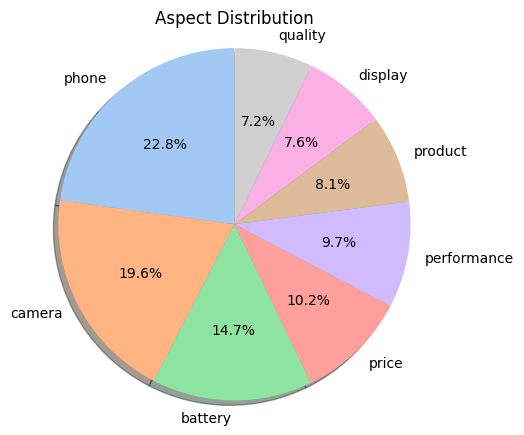

In [ ]:
# Count the occurrences of each aspect
aspect_counts = text_aspect_sentiment_data['aspect'].value_counts()

# Set up figure and axis
plt.figure(figsize=(5,5))

# Create a pie chart with shadow and annotations
plt.pie(aspect_counts, labels=aspect_counts.index, autopct='%1.1f%%', startangle=90, shadow=True, colors=sns.color_palette('pastel'))

# Equal aspect ratio ensures that the pie chart is circular
plt.axis('equal')
plt.title('Aspect Distribution')
plt.show()


- **Phone Aspect:**
  - Represents approximately 15.4% of the total aspects.

- **Camera Aspect:**
  - Represents approximately 13.2% of the total aspects.

- **Battery Aspect:**
  - Represents approximately 9.9% of the total aspects.

- **Price Aspect:**
  - Represents approximately 6.8% of the total aspects.

- **Performance Aspect:**
  - Represents approximately 6.5% of the total aspects.

- **Product Aspect:**
  - Represents approximately 5.4% of the total aspects.

- **Display Aspect:**
  - Represents approximately 5.1% of the total aspects.

- **Quality Aspect:**
  - Represents approximately 4.8% of the total aspects.

These percentages provide a relative measure of the distribution of each aspect in the dataset, indicating the proportional importance of each aspect in user reviews.

### **Data Splitting**

In [ ]:
sentences = text_aspect_sentiment_data['sentence'].to_list()
aspects = text_aspect_sentiment_data['aspect'].to_list()
sentiment_labels = text_aspect_sentiment_data['sentiment'].to_list()  # 1: Positive, 0: Negative


# Create a combined list of sentences and aspects
all_text = sentences + aspects

# Create a word index using all_text
word_index = {word: idx + 1 for idx, word in enumerate(set(' '.join(all_text).split()))}

# Convert sentences and aspects to sequences using word_index
seq_sentences = [[word_index[word] for word in sentence.split()] for sentence in sentences]
seq_aspects = [[word_index[word] for word in aspect.split()] for aspect in aspects]

# Pad sequences to ensure equal length
padded_sentences = pad_sequences(seq_sentences)
padded_aspects = pad_sequences(seq_aspects)

In [ ]:
from sklearn.model_selection import train_test_split

X = np.hstack((padded_sentences, padded_aspects))

X_train, X_test, y_train, y_test = train_test_split(X, sentiment_labels, test_size=0.2, random_state=42, stratify=sentiment_labels)

In [ ]:
padded_sentences_X_train = X_train[:, :padded_sentences.shape[1]]
padded_aspects_X_train = X_train[:, padded_sentences.shape[1]:]

padded_sentences_X_test = X_test[:, :padded_sentences.shape[1]]
padded_aspects_X_test = X_test[:, padded_sentences.shape[1]:]

print("Shapes Information\n")
print("padded_sentences_X_train: ", padded_sentences_X_train.shape)
print("padded_aspects_X_train: ", padded_aspects_X_train.shape)
print("padded_sentences_X_test: ", padded_sentences_X_test.shape)
print("padded_aspects_X_test: ", padded_aspects_X_test.shape)
print("y_train: ", np.array(y_train).shape)
print("y_test: ", np.array(y_test).shape)

Shapes Information

padded_sentences_X_train:  (19534, 84)
padded_aspects_X_train:  (19534, 1)
padded_sentences_X_test:  (4884, 84)
padded_aspects_X_test:  (4884, 1)
y_train:  (19534,)
y_test:  (4884,)


### **Classification Model - LSTM**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Flatten, Reshape
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Flatten, Reshape



# Define the model architecture
embedding_dim = 50
vocab_size = len(word_index) + 1

text_input = Input(shape=(padded_sentences.shape[1],))
aspect_input = Input(shape=(padded_aspects.shape[1],))

# Use Embedding layer directly
text_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(text_input)
aspect_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(aspect_input)

# Flatten the embeddings
flat_text_embedding = Flatten()(text_embedding)
flat_aspect_embedding = Flatten()(aspect_embedding)

# Concatenate flattened embeddings
merged = Concatenate(axis=-1)([flat_text_embedding, flat_aspect_embedding])

# Reshape the concatenated output for LSTM input
reshaped_merged = Reshape((1, -1))(merged)

# LSTM layer for sequence modeling
lstm_out = LSTM(100)(reshaped_merged)

# Dense layer for sentiment classification
output = Dense(1, activation='sigmoid')(lstm_out)

# Compile the model
model = Model(inputs=[text_input, aspect_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
lstm_model = model.fit([padded_sentences_X_train, padded_aspects_X_train], np.array(y_train), epochs=10, batch_size=64, validation_split=0.2)


Epoch 1/10
245/245 [==============================] - 21s 75ms/step - loss: 0.3527 - accuracy: 0.8357 - val_loss: 0.2589 - val_accuracy: 0.8892
Epoch 2/10
245/245 [==============================] - 12s 50ms/step - loss: 0.2143 - accuracy: 0.9103 - val_loss: 0.2543 - val_accuracy: 0.8869
Epoch 3/10
245/245 [==============================] - 11s 47ms/step - loss: 0.1838 - accuracy: 0.9195 - val_loss: 0.2614 - val_accuracy: 0.8861
Epoch 4/10
245/245 [==============================] - 15s 60ms/step - loss: 0.1647 - accuracy: 0.9218 - val_loss: 0.2601 - val_accuracy: 0.8887
Epoch 5/10
245/245 [==============================] - 13s 54ms/step - loss: 0.1537 - accuracy: 0.9250 - val_loss: 0.2733 - val_accuracy: 0.8858
Epoch 6/10
245/245 [==============================] - 13s 53ms/step - loss: 0.1442 - accuracy: 0.9286 - val_loss: 0.2880 - val_accuracy: 0.8894
Epoch 7/10
245/245 [==============================] - 11s 46ms/step - loss: 0.1365 - accuracy: 0.9288 - val_loss: 0.3002 - val_accuracy:

#### Model Summary and Evaluation

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 84)]                 0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 84, 50)               377550    ['input_3[0][0]']             
                                                                                                  
 embedding_3 (Embedding)     (None, 1, 50)                377550    ['input_4[0][0]']             
                                                                                            

In [ ]:
binary_crossentropy_loss_test, accuracy_test = model.evaluate([padded_sentences_X_test, padded_aspects_X_test], np.array(y_test))

153/153 [==============================] - 1s 9ms/step - loss: 0.4049 - accuracy: 0.8825


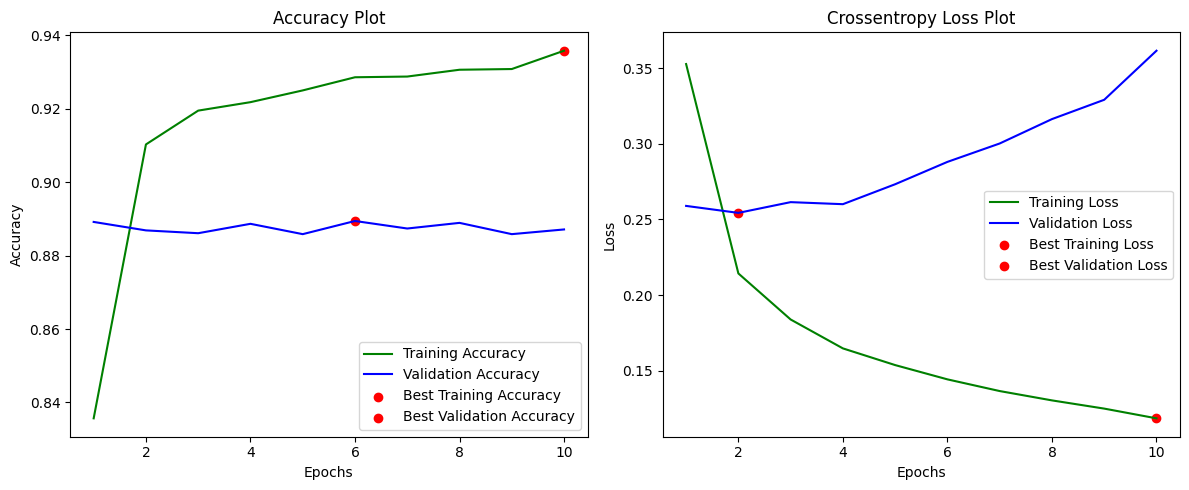

In [ ]:
from sklearn.metrics import accuracy_score

# Extract accuracy and loss values from the history
train_accuracy = lstm_model.history['accuracy']
val_accuracy = lstm_model.history['val_accuracy']
train_loss = lstm_model.history['loss']
val_loss = lstm_model.history['val_loss']

# Find the epoch with the highest accuracy and lowest loss for training and validation
best_epoch_train_acc = np.argmax(train_accuracy) + 1
best_epoch_val_acc = np.argmax(val_accuracy) + 1
best_epoch_train_loss = np.argmin(train_loss) + 1
best_epoch_val_loss = np.argmin(val_loss) + 1

# Set up figure and axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot Accuracy
axes[0].plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy', color='green')
axes[0].plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy', color='blue')

# Mark highest accuracy points
axes[0].scatter(best_epoch_train_acc, max(train_accuracy), color='red', marker='o', label='Best Training Accuracy')
axes[0].scatter(best_epoch_val_acc, max(val_accuracy), color='red', marker='o', label='Best Validation Accuracy')

axes[0].set_title('Accuracy Plot')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Plot Crossentropy Loss
axes[1].plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss', color='green')
axes[1].plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', color='blue')

# Mark lowest loss points
axes[1].scatter(best_epoch_train_loss, min(train_loss), color='red', marker='o', label='Best Training Loss')
axes[1].scatter(best_epoch_val_loss, min(val_loss), color='red', marker='o', label='Best Validation Loss')

axes[1].set_title('Crossentropy Loss Plot')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()


153/153 [==============================] - 1s 10ms/step


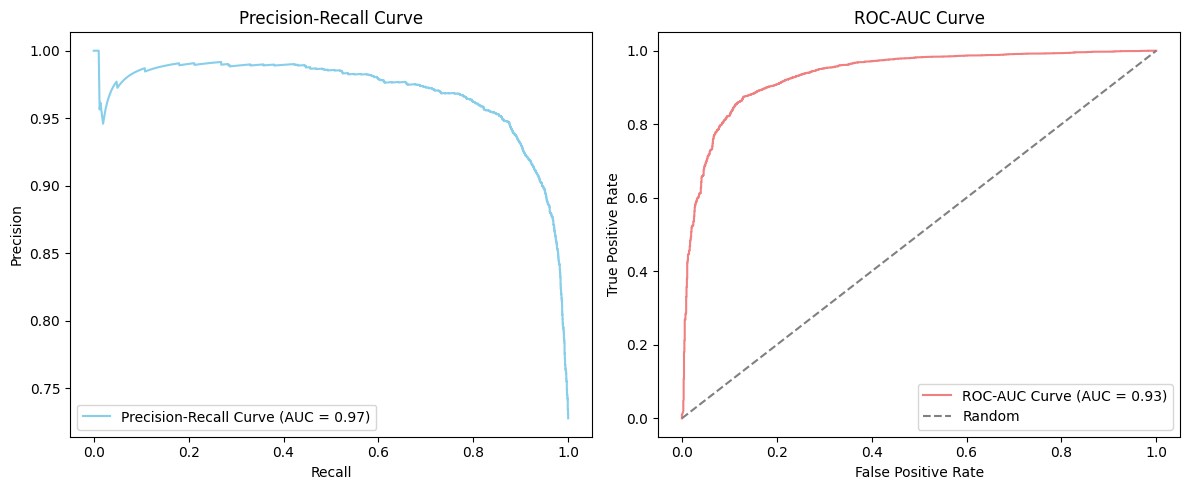

F1 Score: 0.92


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np

# Assuming you have already trained the LSTM model (lstm_model)

# Sample data (replace with your actual data)
y_pred_prob = model.predict([padded_sentences_X_test, padded_aspects_X_test])

# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
area_under_pr_curve = auc(recall, precision)

# ROC-AUC Curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
area_under_roc_curve = auc(fpr, tpr)

# F1 Score
f1_lstm = f1_score(y_test, np.round(y_pred_prob))

# Set up figure and axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot Precision-Recall Curve
axes[0].plot(recall, precision, label='Precision-Recall Curve (AUC = {:.2f})'.format(area_under_pr_curve), color='skyblue')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].set_title('Precision-Recall Curve')
axes[0].legend()

# Plot ROC-AUC Curve
axes[1].plot(fpr, tpr, label='ROC-AUC Curve (AUC = {:.2f})'.format(area_under_roc_curve), color='lightcoral')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC-AUC Curve')
axes[1].legend()

plt.tight_layout()
plt.show()

# Print F1 Score
print('F1 Score: {:.2f}'.format(f1_lstm))

Text(0.5, 1.0, 'Confusion Matrix')

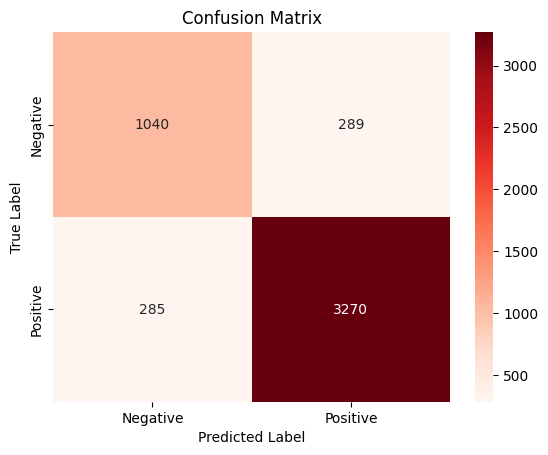

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix


# Sample data (replace with your actual data)
y_pred = np.round(y_pred_prob)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
sns.heatmap(conf_matrix, annot=True, cmap='Reds', fmt='g', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# plt.show()


In [ ]:
print("ESTIMATES SCORES\n")
print("LSTM - binary_crossentropy_loss_test: ", binary_crossentropy_loss_test)
print("LSTM - accuracy_test: ", accuracy_test)
print("LSTM - F1 Score: ", f1_lstm)

ESTIMATES SCORES

LSTM - binary_crossentropy_loss_test:  0.40485501289367676
LSTM - accuracy_test:  0.8824734091758728
LSTM - F1 Score:  0.9119215799336888


### **Classification Model - BiLSTM**

In [ ]:
from tensorflow.keras.layers import Bidirectional, LSTM, Embedding, Flatten, Concatenate, Reshape, Dense, Input, MaxPooling1D, AveragePooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D

# Define the model architecture
embedding_dim = 50
vocab_size = len(word_index) + 1

text_input = Input(shape=(padded_sentences.shape[1],))
aspect_input = Input(shape=(padded_aspects.shape[1],))

# Use Embedding layer directly
text_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(text_input)
aspect_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(aspect_input)

# Bidirectional LSTM layers for sequence modeling
text_lstm = Bidirectional(LSTM(100, return_sequences=True))(text_embedding)
aspect_lstm = Bidirectional(LSTM(100, return_sequences=True))(aspect_embedding)

# GlobalMaxPooling1D layer
text_maxpool = GlobalMaxPooling1D()(text_lstm)
aspect_maxpool = GlobalMaxPooling1D()(aspect_lstm)

# GlobalAveragePooling1D layer
text_avgpool = GlobalAveragePooling1D()(text_lstm)
aspect_avgpool = GlobalAveragePooling1D()(aspect_lstm)

# Flatten the pooled outputs
flat_text_maxpool = Flatten()(text_maxpool)
flat_aspect_maxpool = Flatten()(aspect_maxpool)
flat_text_avgpool = Flatten()(text_avgpool)
flat_aspect_avgpool = Flatten()(aspect_avgpool)

# Concatenate the flattened outputs
merged = Concatenate(axis=-1)([flat_text_maxpool, flat_aspect_maxpool, flat_text_avgpool, flat_aspect_avgpool])

# Reshape the concatenated output for LSTM input
reshaped_merged = Reshape((1, -1))(merged)

# LSTM layer for sequence modeling
lstm_out = LSTM(100)(reshaped_merged)

# Dense layer for sentiment classification
output = Dense(1, activation='sigmoid')(lstm_out)

# Compile the model
model = Model(inputs=[text_input, aspect_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
bilstm_model = model.fit([padded_sentences_X_train, padded_aspects_X_train], np.array(y_train), epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
245/245 [==============================] - 107s 384ms/step - loss: 0.3961 - accuracy: 0.8206 - val_loss: 0.2749 - val_accuracy: 0.8830
Epoch 2/10
245/245 [==============================] - 96s 391ms/step - loss: 0.2347 - accuracy: 0.9020 - val_loss: 0.2550 - val_accuracy: 0.8928
Epoch 3/10
245/245 [==============================] - 80s 327ms/step - loss: 0.2044 - accuracy: 0.9145 - val_loss: 0.2537 - val_accuracy: 0.8961
Epoch 4/10
245/245 [==============================] - 69s 281ms/step - loss: 0.1836 - accuracy: 0.9197 - val_loss: 0.2510 - val_accuracy: 0.8933
Epoch 5/10
245/245 [==============================] - 68s 277ms/step - loss: 0.1685 - accuracy: 0.9248 - val_loss: 0.2841 - val_accuracy: 0.8963
Epoch 6/10
245/245 [==============================] - 68s 278ms/step - loss: 0.1564 - accuracy: 0.9243 - val_loss: 0.2735 - val_accuracy: 0.8917
Epoch 7/10
245/245 [==============================] - 67s 274ms/step - loss: 0.1461 - accuracy: 0.9262 - val_loss: 0.3286 - val_a

#### Model Summary and Evaluation

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 84)]                 0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_6 (Embedding)     (None, 84, 50)               377550    ['input_7[0][0]']             
                                                                                                  
 embedding_7 (Embedding)     (None, 1, 50)                377550    ['input_8[0][0]']             
                                                                                            

In [ ]:
binary_crossentropy_loss_test_bilstm, accuracy_test_bilstm = model.evaluate([padded_sentences_X_test, padded_aspects_X_test], np.array(y_test))

153/153 [==============================] - 7s 45ms/step - loss: 0.3745 - accuracy: 0.8749


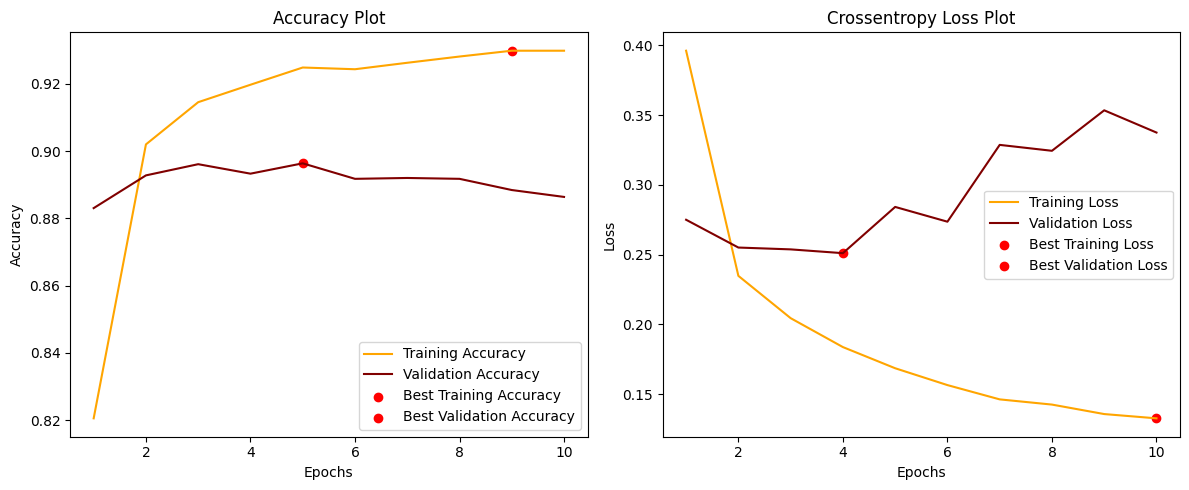

In [ ]:
from sklearn.metrics import accuracy_score

# Extract accuracy and loss values from the history
train_accuracy = bilstm_model.history['accuracy']
val_accuracy = bilstm_model.history['val_accuracy']
train_loss = bilstm_model.history['loss']
val_loss = bilstm_model.history['val_loss']

# Find the epoch with the highest accuracy and lowest loss for training and validation__
best_epoch_train_acc = np.argmax(train_accuracy) + 1
best_epoch_val_acc = np.argmax(val_accuracy) + 1
best_epoch_train_loss = np.argmin(train_loss) + 1
best_epoch_val_loss = np.argmin(val_loss) + 1

# Set up figure and axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot Accuracy
axes[0].plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy', color='orange')
axes[0].plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy', color='maroon')

# Mark highest accuracy points
axes[0].scatter(best_epoch_train_acc, max(train_accuracy), color='red', marker='o', label='Best Training Accuracy')
axes[0].scatter(best_epoch_val_acc, max(val_accuracy), color='red', marker='o', label='Best Validation Accuracy')

axes[0].set_title('Accuracy Plot')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Plot Crossentropy Loss
axes[1].plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss', color='orange')
axes[1].plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', color='maroon')

# Mark lowest loss points
axes[1].scatter(best_epoch_train_loss, min(train_loss), color='red', marker='o', label='Best Training Loss')
axes[1].scatter(best_epoch_val_loss, min(val_loss), color='red', marker='o', label='Best Validation Loss')

axes[1].set_title('Crossentropy Loss Plot')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()


153/153 [==============================] - 10s 64ms/step


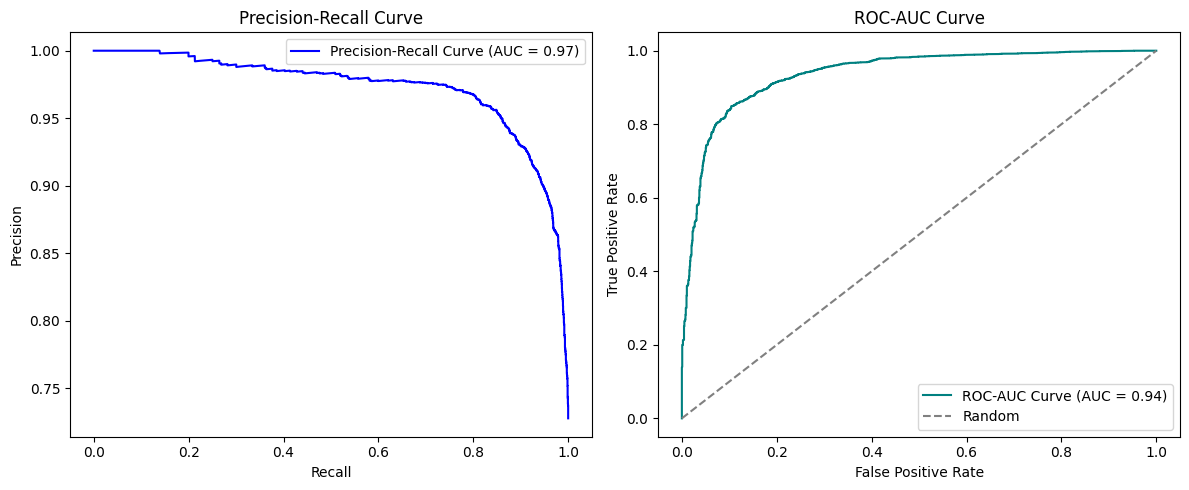

F1 Score: 0.91


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np


y_pred_prob = model.predict([padded_sentences_X_test, padded_aspects_X_test])

# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
area_under_pr_curve = auc(recall, precision)

# ROC-AUC Curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
area_under_roc_curve = auc(fpr, tpr)

# F1 Score
f1_bilstm = f1_score(y_test, np.round(y_pred_prob))

# Set up figure and axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot Precision-Recall Curve
axes[0].plot(recall, precision, label='Precision-Recall Curve (AUC = {:.2f})'.format(area_under_pr_curve), color='blue')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].set_title('Precision-Recall Curve')
axes[0].legend()

# Plot ROC-AUC Curve
axes[1].plot(fpr, tpr, label='ROC-AUC Curve (AUC = {:.2f})'.format(area_under_roc_curve), color='teal')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC-AUC Curve')
axes[1].legend()

plt.tight_layout()
plt.show()

# Print F1 Score
print('F1 Score: {:.2f}'.format(f1_lstm))

Text(0.5, 1.0, 'Confusion Matrix')

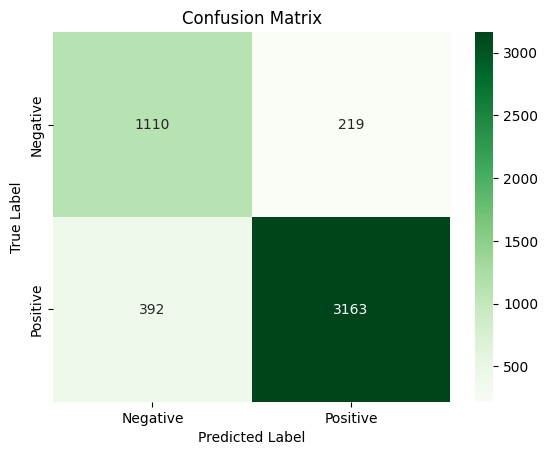

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix


# Sample data (replace with your actual data)
y_pred = np.round(y_pred_prob)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
sns.heatmap(conf_matrix, annot=True, cmap='Greens', fmt='g', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# plt.show()


In [ ]:
print("ESTIMATES SCORES\n")
print("BILSTM - binary_crossentropy_loss_test: ", binary_crossentropy_loss_test_bilstm)
print("BILSTM - accuracy_test: ", accuracy_test_bilstm)
print("BILSTM - F1 Score: ", f1_bilstm)

ESTIMATES SCORES

BILSTM - binary_crossentropy_loss_test:  0.37454697489738464
BILSTM - accuracy_test:  0.8748975992202759
BILSTM - F1 Score:  0.9119215799336888


### **Classification Model - Enhanced BiLSTM**

In [ ]:
import math
from tensorflow.keras.layers import Bidirectional, LSTM, Embedding, Flatten, Concatenate, Reshape, Dense, Input, SpatialDropout1D, Dropout, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# Define the model architecture
embedding_dim = 50
vocab_size = len(word_index) + 1

text_input = Input(shape=(padded_sentences.shape[1],))
aspect_input = Input(shape=(padded_aspects.shape[1],))

# Use Embedding layer directly with SpatialDropout1D
text_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(text_input)
aspect_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(aspect_input)

# Bidirectional LSTM layers for sequence modeling with SpatialDropout1D
text_lstm = Bidirectional(LSTM(100, return_sequences=True))(SpatialDropout1D(0.2)(text_embedding))
aspect_lstm = Bidirectional(LSTM(100, return_sequences=True))(SpatialDropout1D(0.2)(aspect_embedding))

# GlobalMaxPooling1D and GlobalAveragePooling1D layers
text_maxpool = GlobalMaxPooling1D()(text_lstm)
aspect_maxpool = GlobalMaxPooling1D()(aspect_lstm)
text_avgpool = GlobalAveragePooling1D()(text_lstm)
aspect_avgpool = GlobalAveragePooling1D()(aspect_lstm)

# Flatten the pooled outputs
flat_text_maxpool = Flatten()(text_maxpool)
flat_aspect_maxpool = Flatten()(aspect_maxpool)
flat_text_avgpool = Flatten()(text_avgpool)
flat_aspect_avgpool = Flatten()(aspect_avgpool)

# Concatenate the flattened outputs
merged = Concatenate(axis=-1)([flat_text_maxpool, flat_aspect_maxpool, flat_text_avgpool, flat_aspect_avgpool])

# Additional Dense layers with Dropout for regularization
dense1 = Dense(256, activation='relu')(merged)
dropout1 = Dropout(0.5)(dense1)
dense2 = Dense(128, activation='relu')(dropout1)
dropout2 = Dropout(0.3)(dense2)

# Reshape the concatenated output for LSTM input
reshaped_merged = Reshape((1, -1))(dropout2)

# LSTM layer for sequence modeling
lstm_out = LSTM(100)(reshaped_merged)

# Dense layer for sentiment classification
output = Dense(1, activation='sigmoid')(lstm_out)

# Learning rate scheduler function
def lr_schedule(epoch):
    initial_lr = 0.001
    drop = 0.5
    epochs_drop = 5
    lr = initial_lr * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lr

# Learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# Compile the model with Adam optimizer
model = Model(inputs=[text_input, aspect_input], outputs=output)
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with increased epochs and batch size
en_bilstm_model = model.fit([padded_sentences_X_train, padded_aspects_X_train], np.array(y_train), epochs=10, batch_size=128, validation_split=0.2, callbacks=[lr_scheduler])


Epoch 1/10
123/123 [==============================] - 105s 734ms/step - loss: 0.4780 - accuracy: 0.7654 - val_loss: 0.2910 - val_accuracy: 0.8782 - lr: 0.0010
Epoch 2/10
123/123 [==============================] - 78s 634ms/step - loss: 0.2560 - accuracy: 0.8902 - val_loss: 0.2516 - val_accuracy: 0.8945 - lr: 0.0010
Epoch 3/10
123/123 [==============================] - 63s 505ms/step - loss: 0.2118 - accuracy: 0.9112 - val_loss: 0.2525 - val_accuracy: 0.8958 - lr: 0.0010
Epoch 4/10
123/123 [==============================] - 55s 450ms/step - loss: 0.1914 - accuracy: 0.9175 - val_loss: 0.2676 - val_accuracy: 0.8889 - lr: 0.0010
Epoch 5/10
123/123 [==============================] - 57s 466ms/step - loss: 0.1687 - accuracy: 0.9244 - val_loss: 0.2619 - val_accuracy: 0.8920 - lr: 5.0000e-04
Epoch 6/10
123/123 [==============================] - 53s 434ms/step - loss: 0.1604 - accuracy: 0.9276 - val_loss: 0.2623 - val_accuracy: 0.8899 - lr: 5.0000e-04
Epoch 7/10
123/123 [=======================

#### Model Summary and Evaluation

In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 84)]                 0         []                            
                                                                                                  
 input_10 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 embedding_8 (Embedding)     (None, 84, 50)               377550    ['input_9[0][0]']             
                                                                                                  
 embedding_9 (Embedding)     (None, 1, 50)                377550    ['input_10[0][0]']            
                                                                                            

In [ ]:
binary_crossentropy_loss_test_enbilstm, accuracy_test_enbilstm = model.evaluate([padded_sentences_X_test, padded_aspects_X_test], np.array(y_test))

153/153 [==============================] - 7s 47ms/step - loss: 0.3772 - accuracy: 0.8876


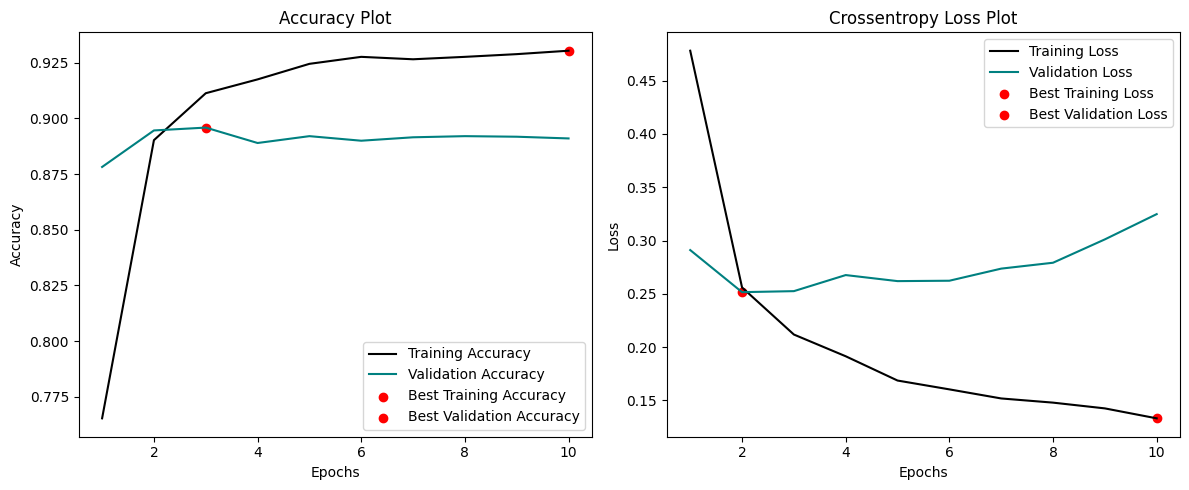

In [ ]:
from sklearn.metrics import accuracy_score

# Extract accuracy and loss values from the history
train_accuracy = en_bilstm_model.history['accuracy']
val_accuracy = en_bilstm_model.history['val_accuracy']
train_loss = en_bilstm_model.history['loss']
val_loss = en_bilstm_model.history['val_loss']

# Find the epoch with the highest accuracy and lowest loss for training and validation
best_epoch_train_acc = np.argmax(train_accuracy) + 1
best_epoch_val_acc = np.argmax(val_accuracy) + 1
best_epoch_train_loss = np.argmin(train_loss) + 1
best_epoch_val_loss = np.argmin(val_loss) + 1

# Set up figure and axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot Accuracy
axes[0].plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy', color='black')
axes[0].plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy', color='teal')

# Mark highest accuracy points
axes[0].scatter(best_epoch_train_acc, max(train_accuracy), color='red', marker='o', label='Best Training Accuracy')
axes[0].scatter(best_epoch_val_acc, max(val_accuracy), color='red', marker='o', label='Best Validation Accuracy')

axes[0].set_title('Accuracy Plot')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Plot Crossentropy Loss
axes[1].plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss', color='black')
axes[1].plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', color='teal')

# Mark lowest loss points
axes[1].scatter(best_epoch_train_loss, min(train_loss), color='red', marker='o', label='Best Training Loss')
axes[1].scatter(best_epoch_val_loss, min(val_loss), color='red', marker='o', label='Best Validation Loss')

axes[1].set_title('Crossentropy Loss Plot')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()


153/153 [==============================] - 7s 32ms/step


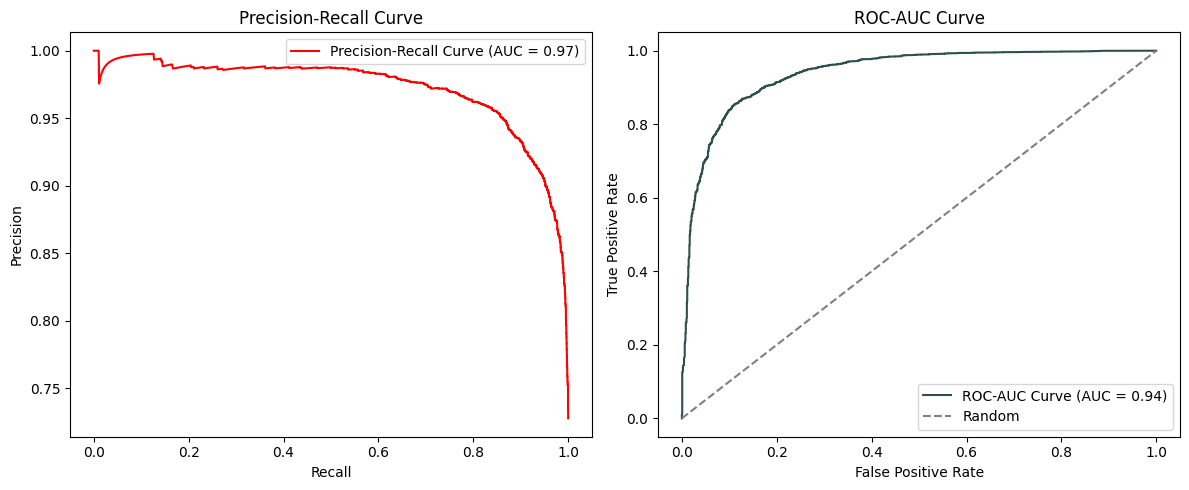

F1 Score: 0.92


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np

# Assuming you have already trained the LSTM model (lstm_model)

# Sample data (replace with your actual data)
y_pred_prob = model.predict([padded_sentences_X_test, padded_aspects_X_test])

# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
area_under_pr_curve = auc(recall, precision)

# ROC-AUC Curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
area_under_roc_curve = auc(fpr, tpr)

# F1 Score
f1_enbilstm = f1_score(y_test, np.round(y_pred_prob))

# Set up figure and axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot Precision-Recall Curve
axes[0].plot(recall, precision, label='Precision-Recall Curve (AUC = {:.2f})'.format(area_under_pr_curve), color='red')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].set_title('Precision-Recall Curve')
axes[0].legend()

# Plot ROC-AUC Curve
axes[1].plot(fpr, tpr, label='ROC-AUC Curve (AUC = {:.2f})'.format(area_under_roc_curve), color='darkslategray')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC-AUC Curve')
axes[1].legend()

plt.tight_layout()
plt.show()

# Print F1 Score
print('F1 Score: {:.2f}'.format(f1_enbilstm))

Text(0.5, 1.0, 'Confusion Matrix')

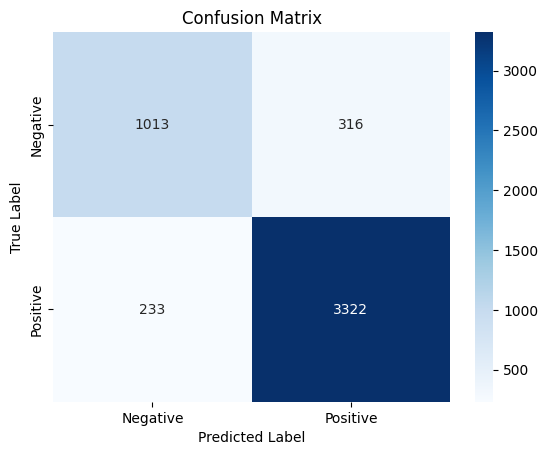

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix


# Sample data (replace with your actual data)
y_pred = np.round(y_pred_prob)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# plt.show()


In [ ]:
print("ESTIMATES SCORES\n")
print("ENHANCED BILSTM - binary_crossentropy_loss_test: ", binary_crossentropy_loss_test_enbilstm)
print("ENHANCED BILSTM - accuracy_test: ", accuracy_test_enbilstm)
print("ENHANCED BILSTM - F1 Score: ", f1_enbilstm)

ESTIMATES SCORES

ENHANCED BILSTM - binary_crossentropy_loss_test:  0.37721359729766846
ENHANCED BILSTM - accuracy_test:  0.8875921368598938
ENHANCED BILSTM - F1 Score:  0.9236757959126929


#### Comapartive Evaluation

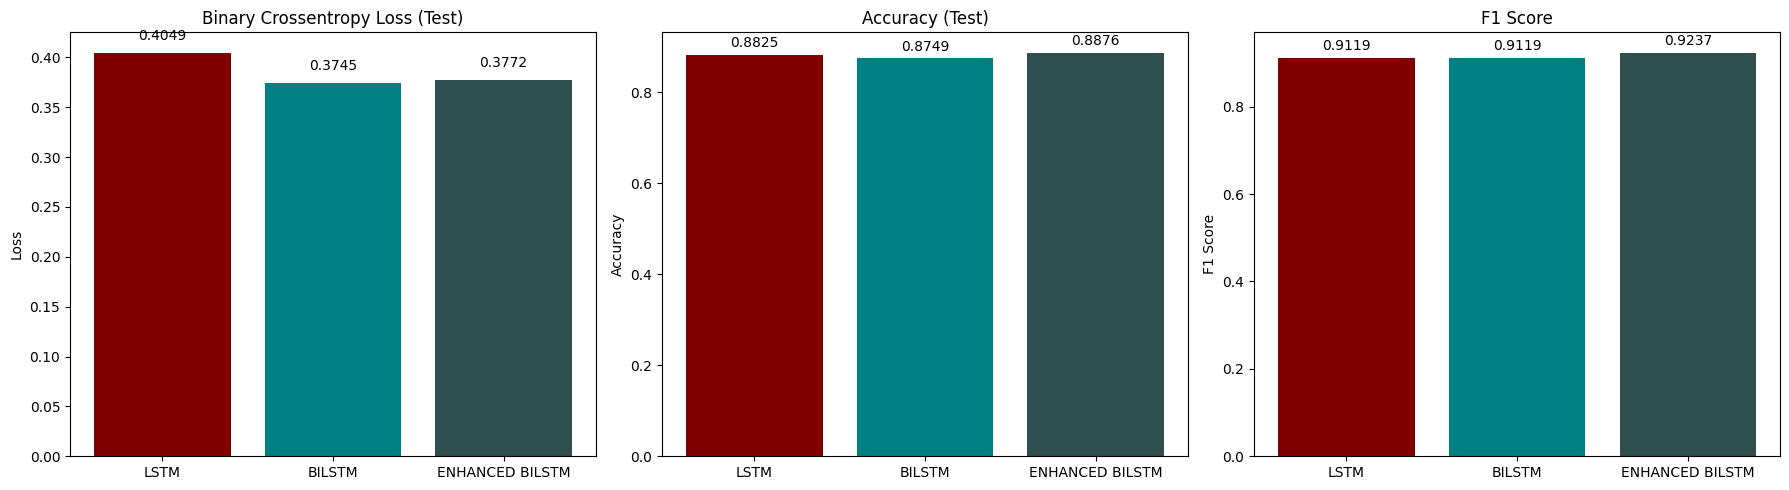

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (replace with your actual data)
models = ['LSTM', 'BILSTM', 'ENHANCED BILSTM']
loss_test = [0.40485501289367676, 0.37454697489738464, 0.37721359729766846]
accuracy_test = [0.8824734091758728, 0.8748975992202759, 0.8875921368598938]
f1_score = [0.9119215799336888, 0.9119215799336888, 0.9236757959126929]

# Set up figure and axes
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

# Plot Binary Crossentropy Loss
axes[0].bar(models, loss_test, color=['maroon', 'teal', 'darkslategray'])
axes[0].set_title('Binary Crossentropy Loss (Test)')
axes[0].set_ylabel('Loss')
for i, v in enumerate(loss_test):
    axes[0].text(i, v + 0.01, round(v, 4), ha='center', va='bottom')

# Plot Accuracy
axes[1].bar(models, accuracy_test, color=['maroon', 'teal', 'darkslategray'])
axes[1].set_title('Accuracy (Test)')
axes[1].set_ylabel('Accuracy')
for i, v in enumerate(accuracy_test):
    axes[1].text(i, v + 0.01, round(v, 4), ha='center', va='bottom')

# Plot F1 Score
axes[2].bar(models, f1_score, color=['maroon', 'teal', 'darkslategray'])
axes[2].set_title('F1 Score')
axes[2].set_ylabel('F1 Score')
for i, v in enumerate(f1_score):
    axes[2].text(i, v + 0.01, round(v, 4), ha='center', va='bottom')

plt.tight_layout()
plt.show()
